<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/probabilistic-programming/probabilistic_programing_vae_tfp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probabilistic Programing VAE using TFP

In [0]:
!git clone -q https://github.com/martin-fabbri/colab-notebooks.git

In [0]:
from IPython.display import Image

## Dependencies & Prerequisited

In [3]:
#@title Install TensorFlow Nightly (ignone any 'gast' related error) { display-mode: "form" }
TF_Installation = 'TF Nightly' #@param ['TF Nightly', 'TF Stable', 'System']

if TF_Installation == 'TF Nightly':
  !pip install -q --upgrade tf-nightly
  print('Installation of `tf-nightly` complete.')
elif TF_Installation == 'TF Stable':
  !pip install -q --upgrade tensorflow
  print('Installation of `tensorflow` complete.')
elif TF_Installation == 'System':
  pass
else:
  raise ValueError('Selection Error: Please select a valid '
                   'installation option.')

     |████████████████████████████████| 511.7MB 29kB/s 
     |████████████████████████████████| 460kB 56.6MB/s 
     |████████████████████████████████| 2.9MB 59.2MB/s 
     |████████████████████████████████| 2.8MB 69.7MB/s 
     |████████████████████████████████| 778kB 54.9MB/s 
ERROR: tensorflow 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
Installation of `tf-nightly` complete.


In [4]:
#@title Install TensorFlow Probability { display-mode: "form" }
TFP_Installation = "Nightly" #@param ["Nightly", "Stable", "System"]

if TFP_Installation == "Nightly":
  !pip install -q tfp-nightly
  print("Installation of `tfp-nightly` complete.")
elif TFP_Installation == "Stable":
  !pip install -q --upgrade tensorflow-probability
  print("Installation of `tensorflow-probability` complete.")
elif TFP_Installation == "System":
  pass
else:
  raise ValueError("Selection Error: Please select a valid "
                   "installation option.")

     |████████████████████████████████| 3.4MB 2.8MB/s 
Installation of `tfp-nightly` complete.


# Probabilistic Programing VAE

Symbol | Represents
:---:|---
$$\mathcal{D}$$ | The dataset, $$\mathcal{D} = { \mathbf{x}^{(1)}, \mathbf{x}^{(2)}, \dots, \mathbf{x}^{(n)} }$$, contains $n$ data samples $\vert\mathcal{D}\vert =n $
$$\mathbf{x}^{(i)}$$ | Each data point is a vector of $d$ dimensions, $$\mathbf{x}^{(i)} = [x^{(i)}_1, x^{(i)}_2, \dots, x^{(i)}_d]$$
$$\mathbf{x}$$	| One data sample from the dataset, $\mathbf{x} \in \mathcal{D}$
$\mathbf{x}’$	| The reconstructed version of $\mathbf{x}$
$$\tilde{\mathbf{x}}$$	| The corrupted version of $\mathbf{x}$
$$\mathbf{z}$$	| The compressed code learned in the bottleneck layer
$$a_j^{(l)}$$	| The activation function for the $j$-th neuron in the $l$-th hidden layer.
$$g_{\phi}(.)$$	| The encoding function parameterized by $\phi$
$$f_{\theta}(.)$$	| The decoding function parameterized by $\theta$
$$q_{\phi}(\mathbf{z}\vert\mathbf{x})$$	| Estimated posterior probability function, also known as probabilistic encoder
$$p_{\theta}(\mathbf{x}\vert\mathbf{z})$$ |	Likelihood of generating true data sample given the latent code, also known as probabilistic decoder




## Autoencoder

The autoencoder architecture is composed by two networks:

- Encode: It translates the otifinal high-dimension input into the latent dimensional code. The input size is larger that the output size.

- Decoder: The decoder network reconstructs the data from the data encoded on the latent layer. 

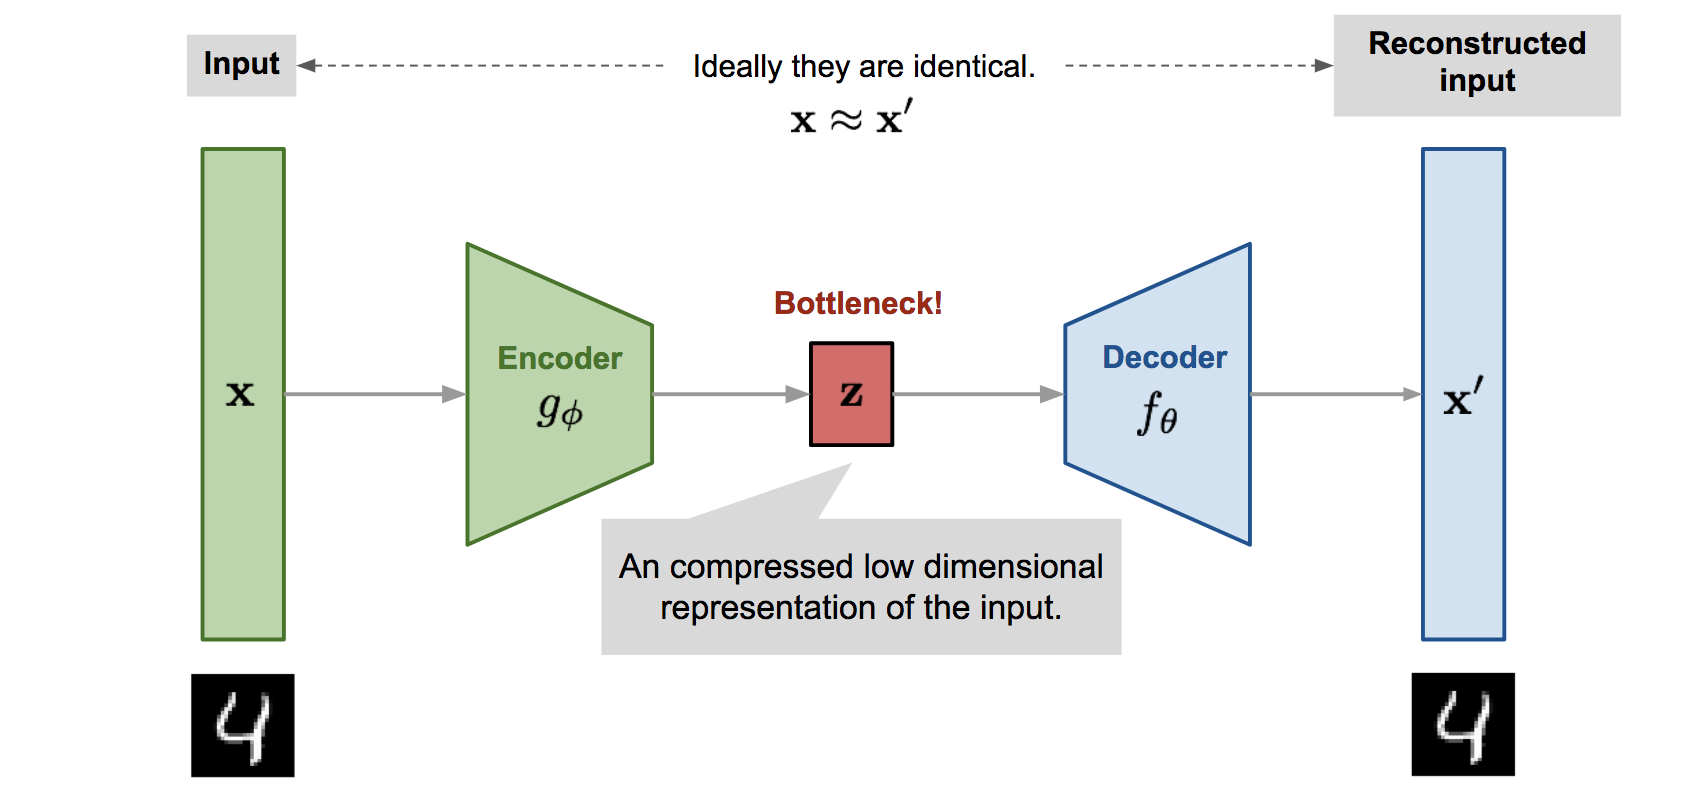

In [5]:
Image(filename='colab-notebooks/probabilistic-programming/images/autoencoder-architecture.png', width=600)

The model contains an encoder function $g(.)$ parameterized by $\phi$ and a decoder function $f(.)$ parameterized by $\theta$. The low-dimensional code learned for input $\mathbf{x}$ in the bottleneck layer is $\mathbf{z}$ and the reconstructed input is $\mathbf{x}' = f_\theta(g_\phi(\mathbf{x}))$.

The parameters $(\theta, \phi)$ are learned together to output a reconstructed data sample same as the original input, $\mathbf{x} \approx f_\theta(g_\phi(\mathbf{x}))$, or in other words, to learn an identity function. There are various metrics to quantify the difference between two vectors, such as cross entropy when the activation function is sigmoid, or as simple as MSE loss:

$$ L_\text{AE}(\theta, \phi) = \frac{1}{n}\sum_{i=1}^n (\mathbf{x}^{(i)} - f_\theta(g_\phi(\mathbf{x}^{(i)})))^2 $$

## Variational Autoencoder



The idea of Variational Autoencoder (Kingma & Welling, 2014), short for VAE, is actually less similar to all the autoencoder architecture described above, but deeply rooted in the methods of variational bayesian and graphical model.

Instead of mapping the input into a fixed vector, we want to map it into a distribution. Let’s label this distribution as $p_\theta$, parameterized by $\theta$. The relationship between the data input $\mathbf{x}$ and the latent encoding vector $\mathbf{z}$ can be fully defined by:

- Prior: $p_\theta(\mathbf{z})$

- Likelihood: $p_\theta(\mathbf{x}\vert\mathbf{z})$

- Posterior: $p_\theta(\mathbf{z}\vert\mathbf{x})$

Assuming that we know the real parameter $\theta^{*}$ for this distribution. In order to generate a sample that looks like a real data point $\mathbf{x}^{(i)}$, we follow these steps:

First, sample a $\mathbf{z}^{(i)}$ from a prior distribution $p_{\theta^*}(\mathbf{z})$.
Then a value $\mathbf{x}^{(i)}$ is generated from a conditional distribution $p_{\theta^*}(\mathbf{x} \vert \mathbf{z} = \mathbf{z}^{(i)})$.

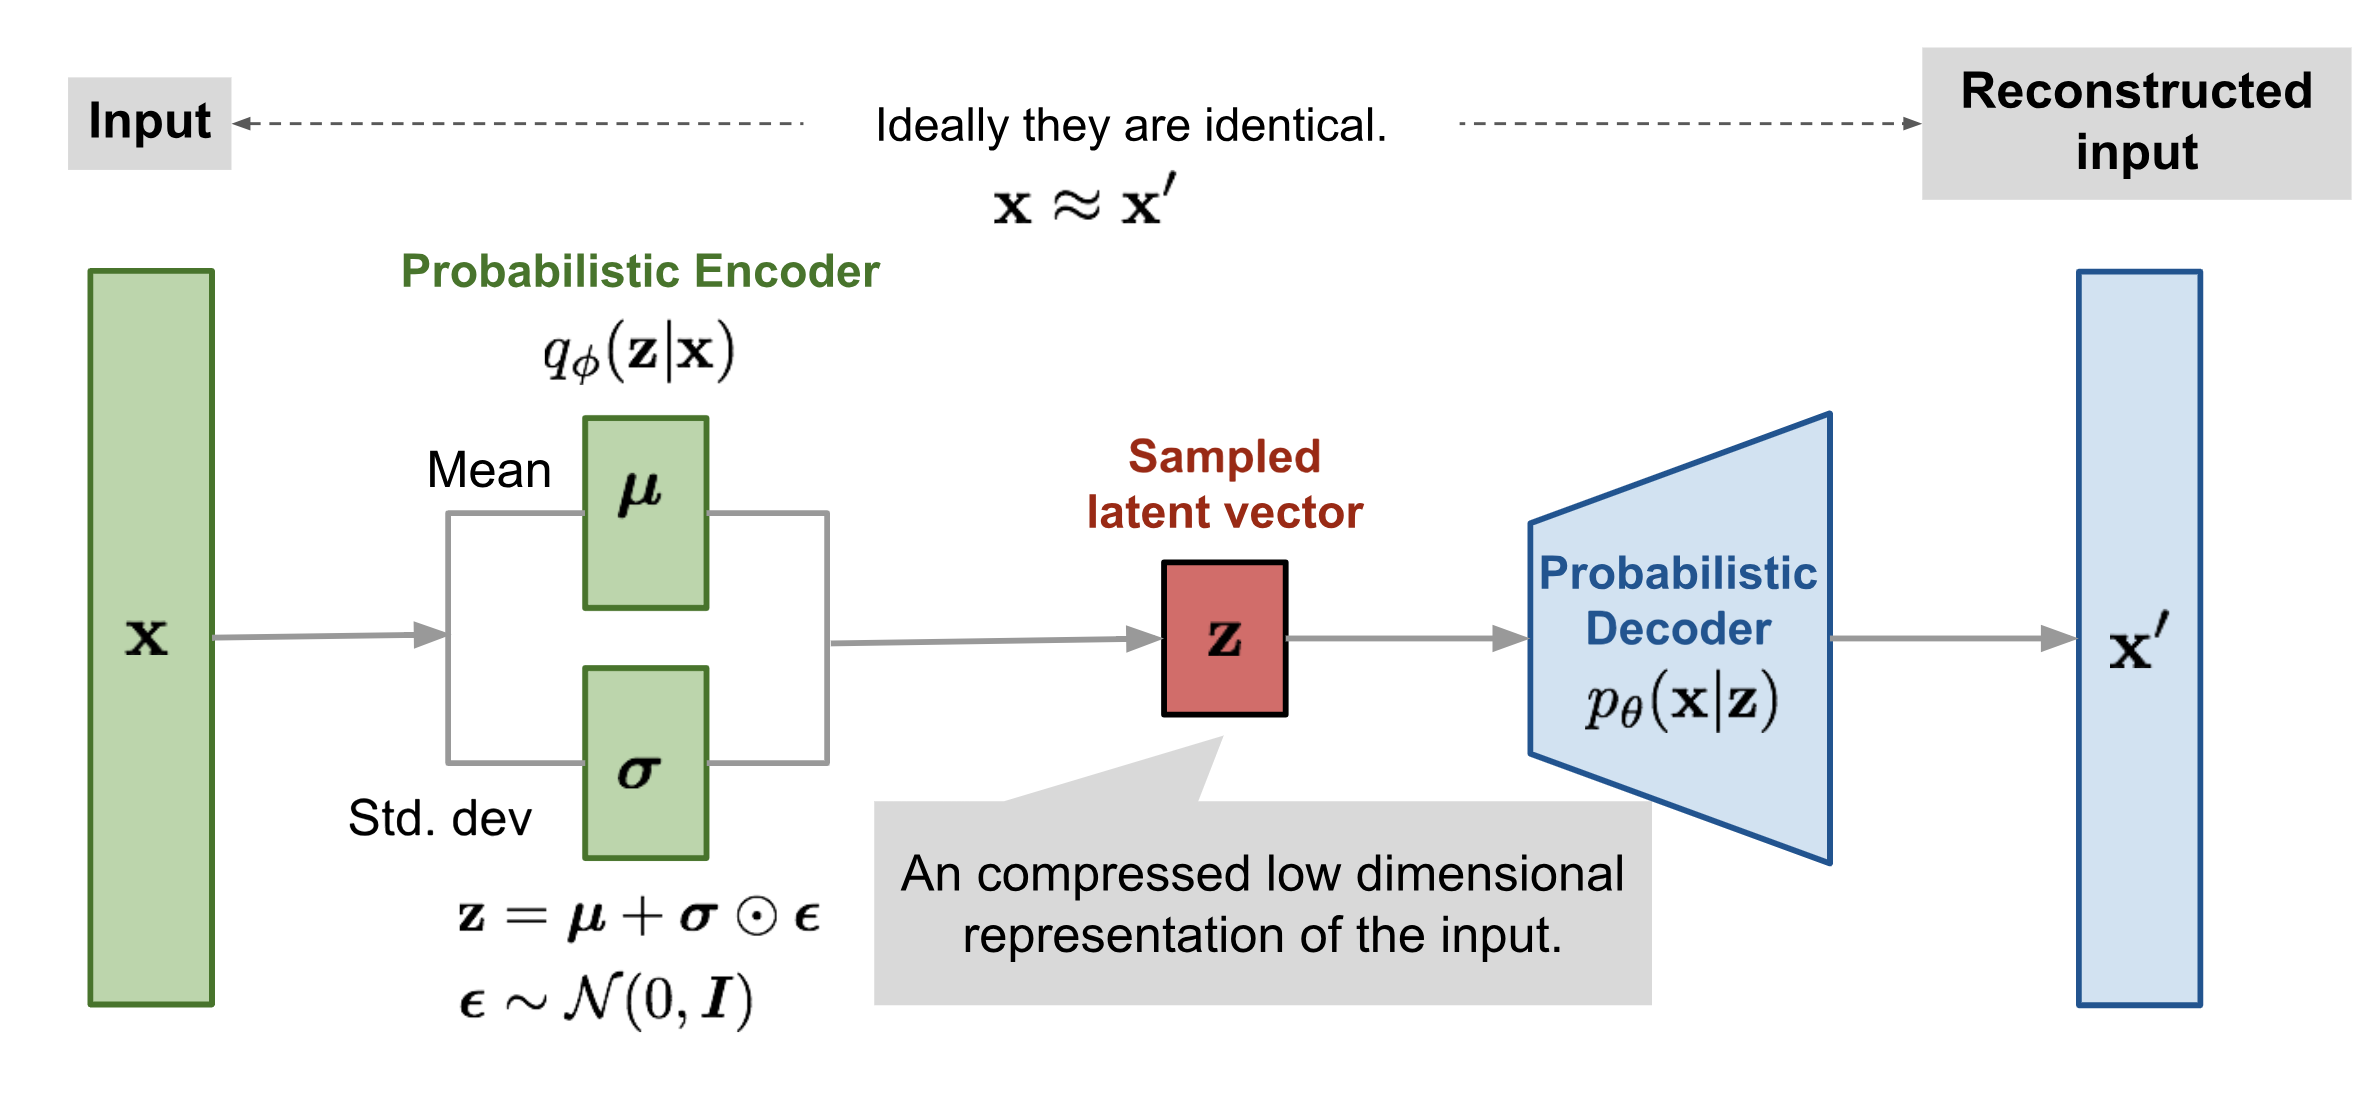

In [6]:
Image(filename='colab-notebooks/probabilistic-programming/images/vae-gaussian.png', width=600)

The optimal parameter $\theta^{*}$ is the one that maximizes the probability of generating real data samples:

$$ \theta^{*} = \arg\max_\theta \prod_{i=1}^n p_\theta(\mathbf{x}^{(i)}) $$

Commonly we use the log probabilities to convert the product on RHS to a sum:

$$ \theta^{*} = \arg\max_\theta \sum_{i=1}^n \log p_\theta(\mathbf{x}^{(i)}) $$

Now let’s update the equation to better demonstrate the data generation process so as to involve the encoding vector:

$$ p_\theta(\mathbf{x}^{(i)}) = \int p_\theta(\mathbf{x}^{(i)}\vert\mathbf{z}) p_\theta(\mathbf{z}) d\mathbf{z} $$

Unfortunately it is not easy to compute $p_\theta(\mathbf{x}^{(i)})$ in this way, as it is very expensive to check all the possible values of $\mathbf{z}$ and sum them up. To narrow down the value space to facilitate faster search, we would like to introduce a new approximation function to output what is a likely code given an input $\mathbf{x}$, $q_\phi(\mathbf{z}\vert\mathbf{x})$, parameterized by $\phi$.

### Encoder (Posterior)

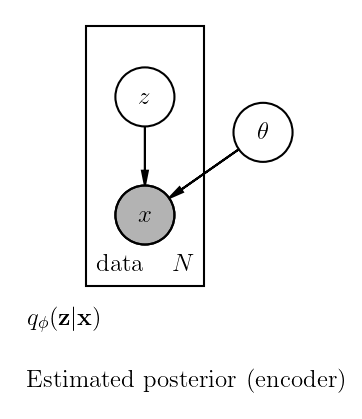

In [7]:
Image(filename='colab-notebooks/probabilistic-programming/images/vae-encoder-plate.png', width=300)

### Decoder (Likelihood)

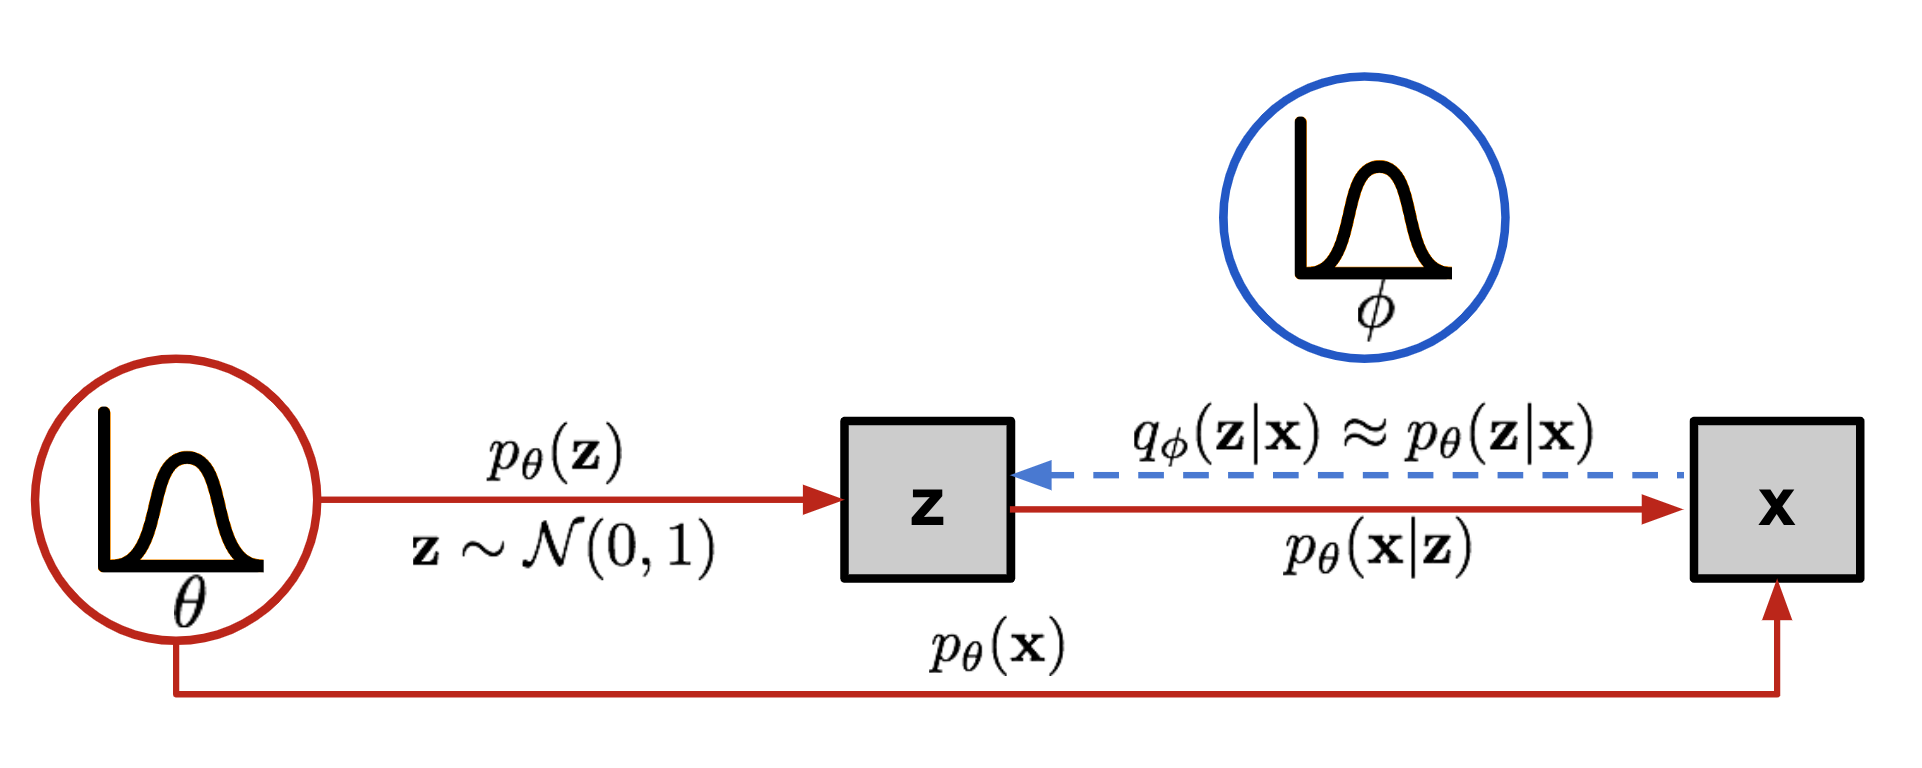

In [8]:
Image(filename='colab-notebooks/probabilistic-programming/images/vae-graphical-model.png', width=600)

On the above graph, solid lines denote the generative distribution $p_\theta(.)$ and dashed lines denote the distribution $q_\phi (\mathbf{z}\vert\mathbf{x})$ to approximate the intractable posterior $p_\theta (\mathbf{z}\vert\mathbf{x})$.

Now the structure looks a lot like an autoencoder:

- The conditional probability $p_\theta(\mathbf{x} \vert \mathbf{z})$ defines a generative model, similar to the decoder $f_\theta(\mathbf{x} \vert \mathbf{z})$ introduced above. $p_\theta(\mathbf{x} \vert \mathbf{z})$ is also known as probabilistic decoder.
- The approximation function $q_\phi(\mathbf{z} \vert \mathbf{x})$ is the probabilistic encoder, playing a similar role as $g_\phi(\mathbf{z} \vert \mathbf{x})$ above.

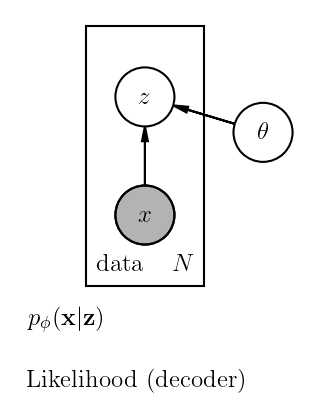

In [9]:
Image(filename='colab-notebooks/probabilistic-programming/images/vae-decoder-plate.png', width=300)

## Loss Function: ELBO

The estimated posterior $q_\phi(\mathbf{z}\vert\mathbf{x})$ should be very close to the real one $p_\theta(\mathbf{z}\vert\mathbf{x})$. We can use Kullback-Leibler divergence to quantify the distance between these two distributions. KL divergence $D_\text{KL}(X|Y)$ measures how much information is lost if the distribution Y is used to represent X.

In our case we want to minimize $D_\text{KL}( q_\phi(\mathbf{z}\vert\mathbf{x}) | p_\theta(\mathbf{z}\vert\mathbf{x}) )$ with respect to $\phi$.

But why use $D_\text{KL}(q_\phi | p_\theta)$ (reversed KL) instead of $D_\text{KL}(p_\theta | q_\phi)$ (forward KL)? Eric Jang has a great explanation in his post on Bayesian Variational methods. As a quick recap:



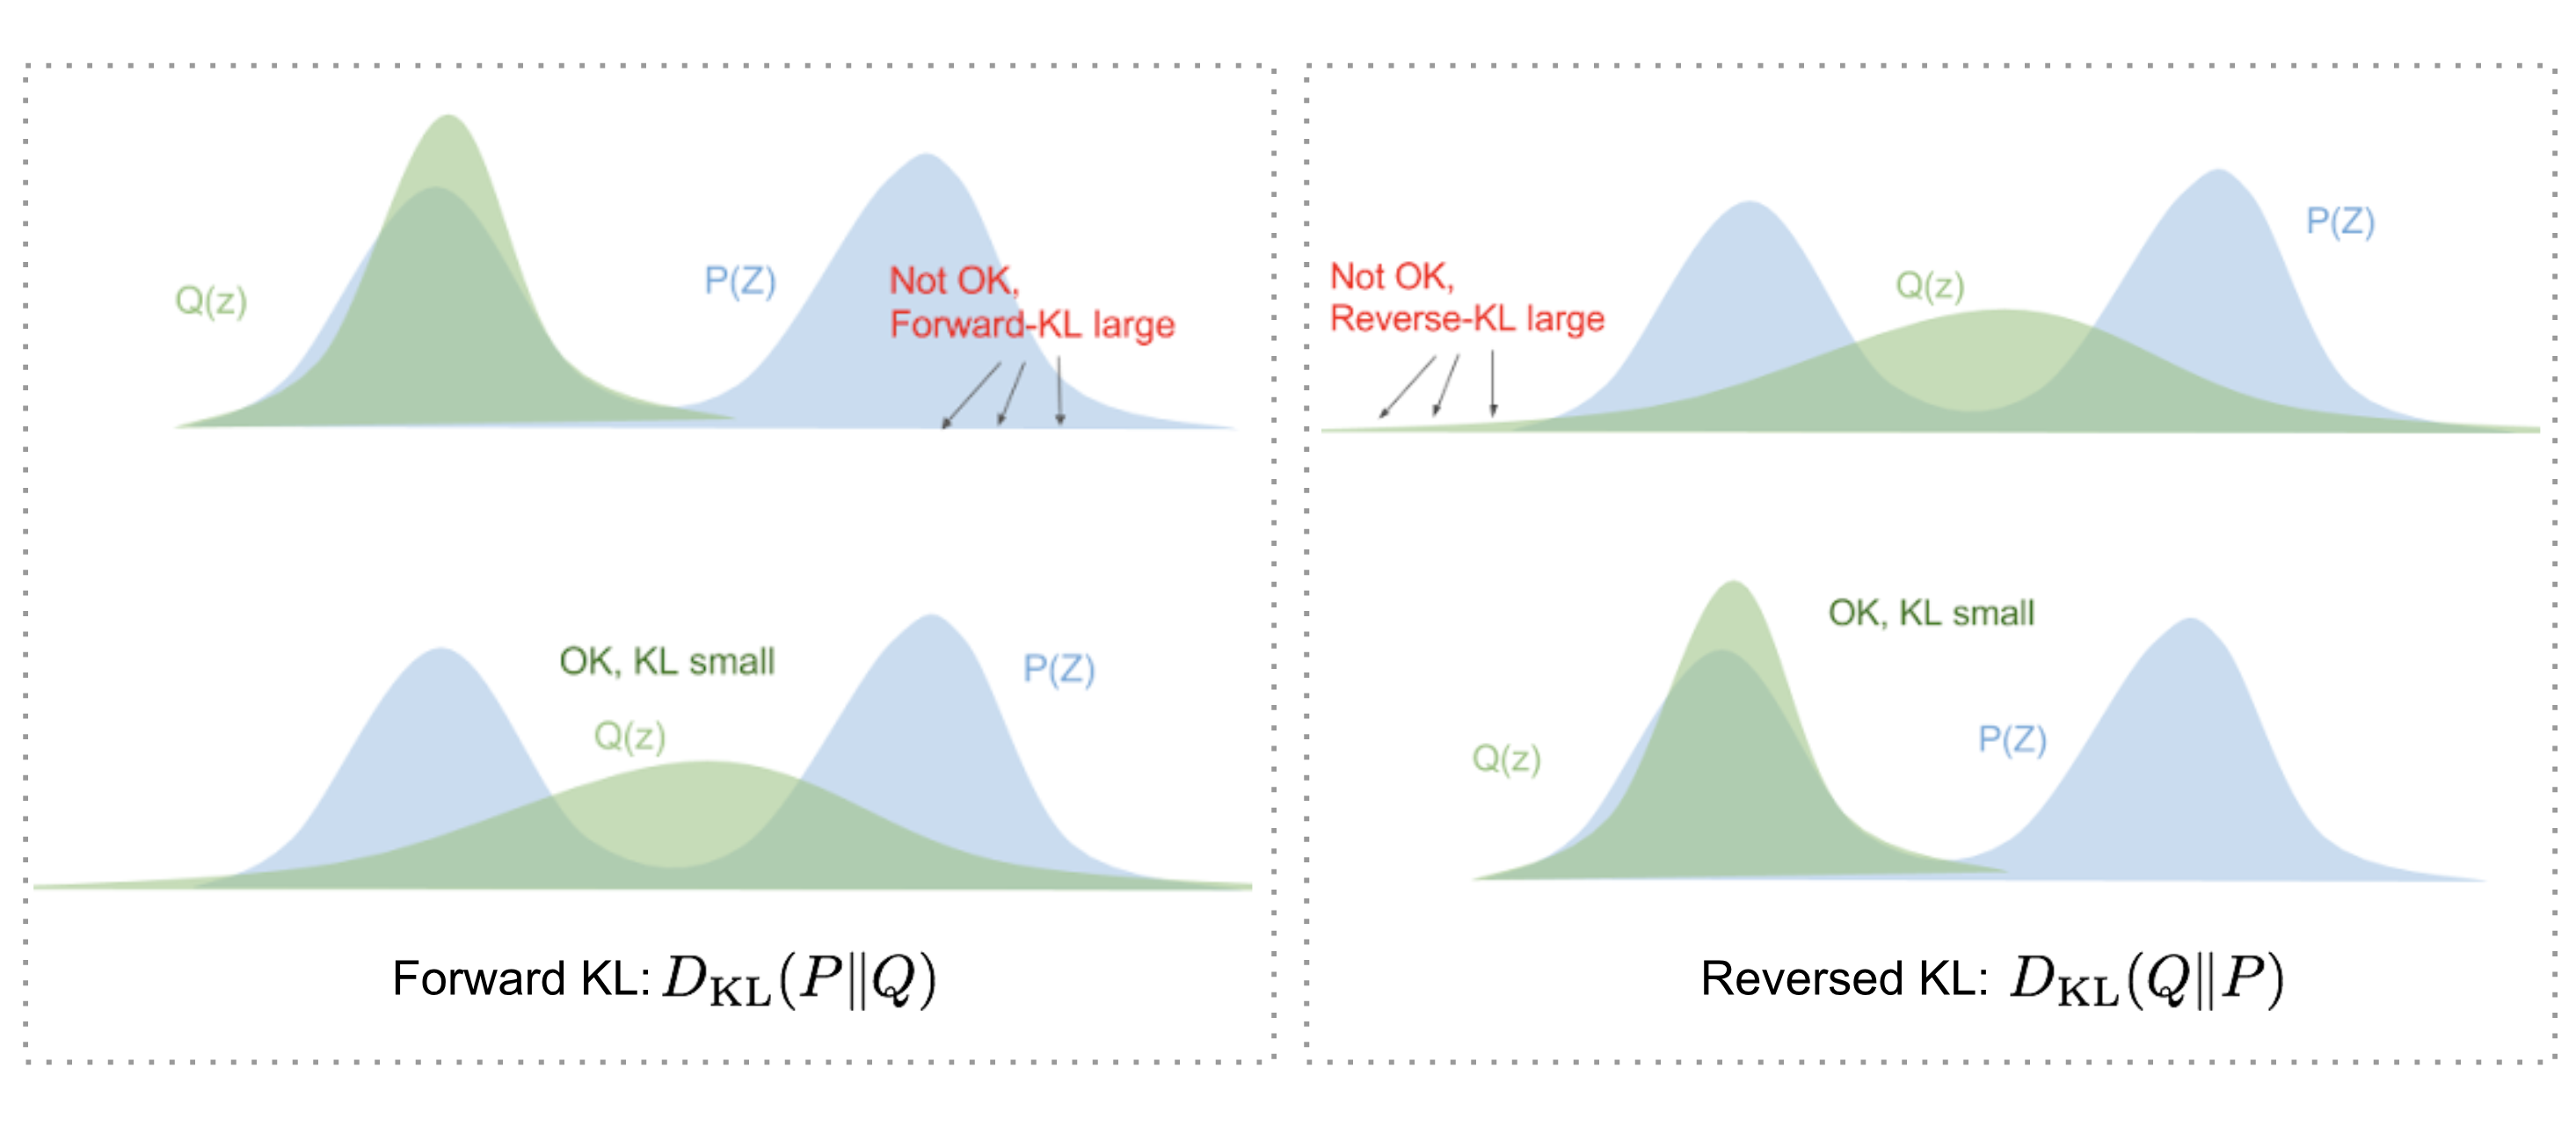

In [10]:
Image(filename='colab-notebooks/probabilistic-programming/images/forward_vs_reversed_kl.png', width=600)

- Forward KL divergence: $D_\text{KL}(P|Q) = \mathbb{E}_{z\sim P(z)} \log\frac{P(z)}{Q(z)}$; we have to ensure that Q(z)>0 wherever P(z)>0. The optimized variational distribution $q(z)$ has to cover over the entire $p(z)$.

- Reversed KL divergence: $D_\text{KL}(Q|P) = \mathbb{E}_{z\sim Q(z)} \log\frac{Q(z)}{P(z)}$; minimizing the reversed KL divergence squeezes the $Q(z)$ under $P(z)$.

Let's now expand the equation:

\begin{aligned}
D_\text{KL}( q_\phi(\mathbf{z}\vert\mathbf{x}) | p_\theta(\mathbf{z}\vert\mathbf{x}) ) 
\end{aligned}

\begin{aligned}
=\log p_\theta(\mathbf{x}) + D_\text{KL}(q_\phi(\mathbf{z}\vert\mathbf{x}) | p_\theta(\mathbf{z})) - \mathbb{E}{\mathbf{z}\sim q\phi(\mathbf{z}\vert\mathbf{x})}\log p_\theta(\mathbf{x}\vert\mathbf{z}) & \end{aligned}

$$ -L_\text{VAE} = \log p_\theta(\mathbf{x}) - D_\text{KL}( q_\phi(\mathbf{z}\vert\mathbf{x}) | p_\theta(\mathbf{z}\vert\mathbf{x}) ) \leq \log p_\theta(\mathbf{x}) $$

Therefore by minimizing the loss, we are maximizing the lower bound of the probability of generating real data samples.

In [28]:
#@title Imports { display-mode: "form" }
import os

import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()


import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras .layers
tfpl = tfp.layers
tfd = tfp.distributions

print(f'TensorFlow: {tf.__version__}')
print(f'TensorFlow Probability: {tfp.__version__}')

TensorFlow: 2.2.0-dev20200218
TensorFlow Probability: 0.10.0-dev20200223


In [29]:
#@title Enabled GPU { display-mode: "form" }
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print(f'SUCCESS: Found GPU: {tf.test.gpu_device_name()}')

!nvidia-smi -L

SUCCESS: Found GPU: /device:GPU:0
GPU 0: Tesla T4 (UUID: GPU-e9dc1d95-0381-0e8e-04f7-a9cd232c78cf)


In [0]:
datasets, datasets_info = tfds.load(name='mnist', with_info=True, as_supervised=False)

def _preprocess(sample):
  image = tf.cast(sample['image'], tf.float32) / 255.
  image = image < tf.random.uniform(tf.shape(image))
  return image, image

train_dataset = (datasets['train']
                 .map(_preprocess)
                 .batch(256)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 .shuffle(int(10e3)))

eval_dataset = (datasets['test']
                .map(_preprocess)
                .batch(256)
                .prefetch(tf.data.experimental.AUTOTUNE))



In [0]:
input_shape = datasets_info.features['image'].shape
encoded_size = 16
base_depth = 32

In [0]:
prior = tfd.Independent(
    tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
    reinterpreted_batch_ndims=1
)

In [0]:
encoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=input_shape),
  tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
  tfkl.Conv2D(base_depth, 5, strides=1, padding='same', 
              activation=tf.nn.leaky_relu),
  tfkl.Conv2D(base_depth, 5, strides=2, padding='same', 
              activation=tf.nn.leaky_relu),
  tfkl.Conv2D(2 * base_depth, 5, strides=1, padding='same', 
              activation=tf.nn.leaky_relu),
  tfkl.Conv2D(2 * base_depth, 5, strides=2, padding='same', 
              activation=tf.nn.leaky_relu),
  tfkl.Conv2D(2 * base_depth, 7, strides=1, padding='valid', 
              activation=tf.nn.leaky_relu),            
  tfkl.Flatten(),
  tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
             activation=None),
  tfpl.MultivariateNormalTriL(encoded_size, 
                              activity_regularizer=tfpl.KLDivergenceRegularizer(prior))
])

In [0]:
decoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[encoded_size]),
  tfkl.Reshape([1, 1, encoded_size]),
  tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1, 
                       padding='valid', activation=tf.nn.leaky_relu),
  tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                       padding='same', activation=tf.nn.leaky_relu),
  tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                        padding='same', activation=tf.nn.leaky_relu),
  tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                        padding='same', activation=tf.nn.leaky_relu),
  tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                        padding='same', activation=tf.nn.leaky_relu),
  tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                        padding='same', activation=tf.nn.leaky_relu),
  tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
              padding='same', activation=None),
  tfkl.Flatten(),
  tfpl.IndependentBernoulli(input_shape, tfd.Bernoulli.logits),
])

In [0]:
vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]))

## Do inference

In [38]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss=negloglik)

_ = vae.fit(train_dataset, epochs=15, validation_data=eval_dataset)

Epoch 1/15
235/235 [==============================] - 30s 128ms/step - loss: 233.7292 - val_loss: 176.7475
Epoch 2/15
235/235 [==============================] - 23s 97ms/step - loss: 158.3223 - val_loss: 147.0154
Epoch 3/15
235/235 [==============================] - 23s 96ms/step - loss: 143.2772 - val_loss: 140.4665
Epoch 4/15
235/235 [==============================] - 23s 97ms/step - loss: 137.1170 - val_loss: 132.4059
Epoch 5/15
235/235 [==============================] - 22s 95ms/step - loss: 131.1231 - val_loss: 128.5426
Epoch 6/15
235/235 [==============================] - 22s 93ms/step - loss: 127.7557 - val_loss: 126.2948
Epoch 7/15
235/235 [==============================] - 22s 94ms/step - loss: 125.6484 - val_loss: 123.8701
Epoch 8/15
235/235 [==============================] - 22s 95ms/step - loss: 124.1125 - val_loss: 122.7619
Epoch 9/15
235/235 [==============================] - 22s 95ms/step - loss: 122.6910 - val_loss: 121.9750
Epoch 10/15
235/235 [========================

In [0]:
#@title Image Plot Util
import matplotlib.pyplot as plt

def display_imgs(x, y=None):
  if not isinstance(x, (np.ndarray, np.generic)):
    x = np.array(x)
  plt.ioff()
  n = x.shape[0]
  fig, axs = plt.subplots(1, n, figsize=(n, 1))
  if y is not None:
    fig.suptitle(np.argmax(y, axis=1))
  for i in range(n):
    axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
    axs.flat[i].axis('off')
  plt.show()
  plt.close()
  plt.ion()

In [0]:
# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]
xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

Originals:


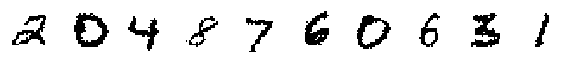

Decoded Random Samples:


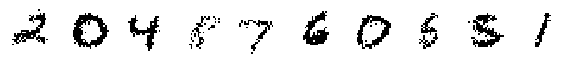

Decoded Modes:


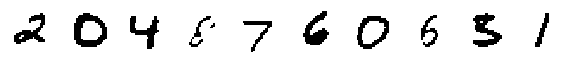

Decoded Means:


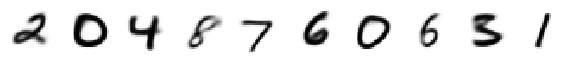

In [47]:
print('Originals:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())

In [0]:
# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
xtilde = decoder(z)
assert isinstance(xtilde, tfd.Distribution)

Randomly Generated Samples:


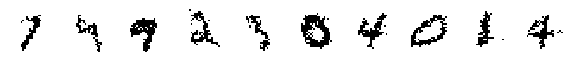

Randomly Generated Modes:


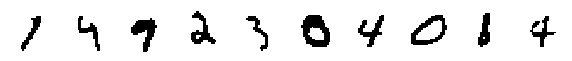

Randomly Generated Means:


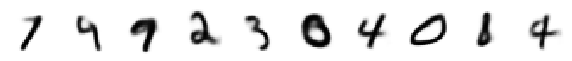

In [49]:
print('Randomly Generated Samples:')
display_imgs(xtilde.sample())

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())